In [65]:

import numpy as np
import idx2numpy
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle
import os

In [66]:
trainImages = 'Mnist/train-images.idx3-ubyte'
trainLabels = 'Mnist/train-labels.idx1-ubyte'
testImages =  'Mnist/t10k-images.idx3-ubyte'
testLabels =  'Mnist/t10k-labels.idx1-ubyte'  

In [67]:
XTrain = idx2numpy.convert_from_file(trainImages)
YTrain = idx2numpy.convert_from_file(trainLabels)  
XTest = idx2numpy.convert_from_file(testImages)
YTest = idx2numpy.convert_from_file(testLabels)

In [68]:
XTrain = XTrain.reshape(XTrain.shape[0], -1)
XTest = XTest.reshape(XTest.shape[0], -1)
XTrain = XTrain / 255.0
XTest = XTest / 255.0
# YTrain = YTrain.astype(int)
YTrainHotencoding = np.eye(10)[YTrain] 
# print(XTrain.shape , YTrainHotencoding.shape)
XTrainSplit , XRem , YTrainSplit , YRem = train_test_split(XTrain , YTrainHotencoding , test_size=0.2 , random_state=42)
# print(XTrainSplit.shape , YTrainSplit.shape , XRem.shape , YRem.shape)
XValSplit , XTestSplit , YValSplit , YTestSplit = train_test_split(XRem , YRem , test_size=0.5 , random_state=42)

Building the NeuralNetwork from scratch

In [73]:
class NeuralNetwork:
    def __init__(self, hiddenlayers, neuronperlayer, activationfn, weightinit, epochs, batchSize, lr=0.1 , earlystop = False , patience = 10): 
        self.hiddenlayers = hiddenlayers
        self.neuronperlayer = neuronperlayer
        self.lr = lr
        self.activationfn = activationfn
        self.weightinit = weightinit
        self.epochs = epochs
        self.batchSize = batchSize
        self.biases = [np.zeros((self.neuronperlayer[i+1], 1)) for i in range(len(self.neuronperlayer) - 1)]
        self.batchSize = batchSize
        self.earlyStopping = earlystop
        self.patience = patience

        if self.weightinit == 'zeroinit':
            self.weights = [np.zeros((self.neuronperlayer[i+1], self.neuronperlayer[i])) for i in range(len(self.neuronperlayer) - 1)]
        elif self.weightinit == 'randominit':
            self.weights = [np.random.randn(self.neuronperlayer[i+1], self.neuronperlayer[i]) * np.sqrt(2.0/self.neuronperlayer[i]) for i in range(len(self.neuronperlayer) - 1)]
        elif self.weightinit == 'normalinit':
            self.weights = [
                np.random.randn(self.neuronperlayer[i+1], self.neuronperlayer[i]) * np.sqrt(2 / (self.neuronperlayer[i] + self.neuronperlayer[i+1]))
                for i in range(len(self.neuronperlayer) - 1)
            ]
    
    def activate(self, x):
        if self.activationfn == 'sigmoid':
            x = np.clip(x, -500, 500)
            return 1 / (1 + np.exp(-x))
        elif self.activationfn == 'tanh':
            return np.tanh(x)
        elif self.activationfn == 'relu':
            return np.maximum(0, x)
        elif self.activationfn == 'leakyrelu':
            return np.maximum(0.01 * x, x)
    
    def activatederivation(self, x , activatedOut = False):
        if self.activationfn == 'sigmoid':
            if activatedOut:
                return x * (1 - x)
            else:
                s = 1 / (1 + np.exp(-x))
                return s * (1 - s)
        elif self.activationfn == 'tanh':
            if activatedOut:
                return 1 - x**2
            else:
                t = np.tanh(x)
                return 1 - t**2
            # return 1 - x**2
        elif self.activationfn == 'relu':
            return (x > 0).astype(float)
        elif self.activationfn == 'leakyrelu':
            return np.where(x > 0, 1, 0.01)
    
    def softmax(self, x):
        exps = np.exp(x - np.max(x, axis=0, keepdims=True))
        return exps / np.sum(exps, axis=0, keepdims=True)
    
    def compute_loss(self, y_pred, y_true):
        m = y_true.shape[1]
        return -np.sum(y_true * np.log(y_pred + 1e-9)) / m

    def fit(self, x, y , xval , yval):
        trainLosses = [] ; valLosses = []
        bestValLoss = float('inf') ; cnt = 0
        for epoch in range(self.epochs):
            for j in range(0, x.shape[0], self.batchSize):
                xbatch = x[j:j+self.batchSize].T
                ybatch = y[j:j+self.batchSize].T
                
                pre_activation = []
                post_activation = [xbatch]

                for k in range(self.hiddenlayers):
                    z = np.dot(self.weights[k], post_activation[-1]) + self.biases[k]
                    pre_activation.append(z)
                    post_activation.append(self.activate(z))

                z_out = np.dot(self.weights[-1], post_activation[-1]) + self.biases[-1]
                pre_activation.append(z_out)
                post_activation.append(self.softmax(z_out))
                
                gradientw = [np.zeros_like(w) for w in self.weights]
                gradientb = [np.zeros_like(b) for b in self.biases]
                err = post_activation[-1] - ybatch
                num_points = xbatch.shape[1]
                gradientw[-1] = (1 / num_points) * np.dot(err, post_activation[-2].T)
                gradientb[-1] = (1 / num_points) * np.sum(err, axis=1, keepdims=True)
            
                for k in range(self.hiddenlayers - 1, -1, -1):
                    err = np.dot(self.weights[k + 1].T, err) * self.activatederivation(pre_activation[k])
                    gradientw[k] = (1 / num_points) * np.dot(err, post_activation[k].T)
                    gradientb[k] = (1 / num_points) * np.sum(err, axis=1, keepdims=True)
                
                for k in range(len(self.weights)):
                    np.clip(gradientw[k], -1, 1, out=gradientw[k])
                    np.clip(gradientb[k], -1, 1, out=gradientb[k])
                    self.weights[k] -= self.lr * gradientw[k]
                    self.biases[k] -= self.lr * gradientb[k]
            trainLoss = self.compute_loss(post_activation[-1] , ybatch)
            valLoss = self.compute_loss(self.predict_proba(xval) , yval)
            trainLosses.append(trainLoss) ; valLosses.append(valLoss)
            if epoch % 10 == 0:
                print(f'Epoch {epoch} : Train Loss = {trainLoss:.4f} , Validation Loss = {valLoss:.4f}')
            if self.earlyStopping:
                if valLoss < bestValLoss:
                    bestValLoss = valLoss
                    cnt = 0
                else:
                    cnt += 1
                    if cnt == self.patience:
                        print(f'Early Stopping at Epoch {epoch}')
                        break
        return trainLosses , valLosses
    
    def predict_proba(self, x):
        activations = x.T
        for i in range(len(self.weights)):
            z = np.dot(self.weights[i], activations) + self.biases[i]
            if i < len(self.weights) - 1:
                activations = self.activate(z)
            else:
                activations = self.softmax(z)
        return activations.T
    
    def predict(self, x):
        prob = self.predict_proba(x)
        return np.argmax(prob, axis=1)
    
    def score(self, x, y):
        ypred = self.predict(x)
        ytrue = np.argmax(y, axis=1)
        return np.mean(ypred == ytrue)

Training on different parameters

Epoch 0 : Train Loss = 2.2947 , Validation Loss = 1380.6427
Epoch 10 : Train Loss = 2.2946 , Validation Loss = 1380.6413
Epoch 20 : Train Loss = 2.2946 , Validation Loss = 1380.6395
Epoch 30 : Train Loss = 2.2946 , Validation Loss = 1380.6378
Epoch 40 : Train Loss = 2.2945 , Validation Loss = 1380.6361
Epoch 50 : Train Loss = 2.2945 , Validation Loss = 1380.6344
Epoch 60 : Train Loss = 2.2945 , Validation Loss = 1380.6328
Epoch 70 : Train Loss = 2.2945 , Validation Loss = 1380.6311
Epoch 80 : Train Loss = 2.2944 , Validation Loss = 1380.6296
Epoch 90 : Train Loss = 2.2944 , Validation Loss = 1380.6280


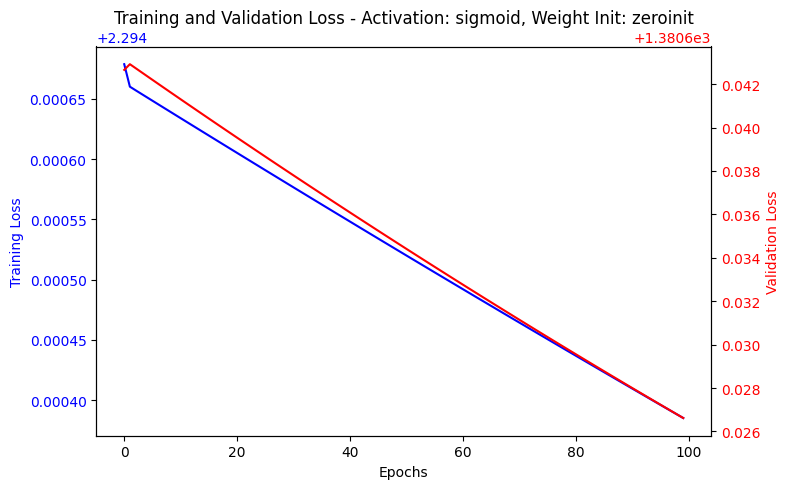

Model with Activation: sigmoid, Weight Init: zeroinit - Validation Accuracy: 11.37%, Test Accuracy: 10.67%
Epoch 0 : Train Loss = 2.2941 , Validation Loss = 1380.0817
Epoch 10 : Train Loss = 2.2679 , Validation Loss = 1365.2647
Epoch 20 : Train Loss = 1.5715 , Validation Loss = 961.6566
Epoch 30 : Train Loss = 0.8651 , Validation Loss = 552.8595
Epoch 40 : Train Loss = 0.6426 , Validation Loss = 420.9423
Epoch 50 : Train Loss = 0.5222 , Validation Loss = 344.4037
Epoch 60 : Train Loss = 0.4183 , Validation Loss = 277.5873
Epoch 70 : Train Loss = 0.3461 , Validation Loss = 229.7360
Epoch 80 : Train Loss = 0.3082 , Validation Loss = 200.6008
Epoch 90 : Train Loss = 0.2818 , Validation Loss = 179.5652


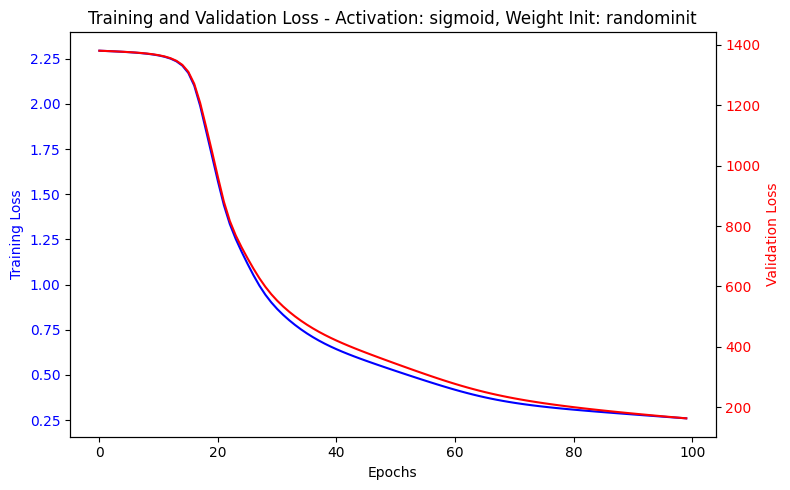

Model with Activation: sigmoid, Weight Init: randominit - Validation Accuracy: 92.53%, Test Accuracy: 92.10%
Epoch 0 : Train Loss = 2.2942 , Validation Loss = 1380.1777
Epoch 10 : Train Loss = 2.2869 , Validation Loss = 1375.6992
Epoch 20 : Train Loss = 2.1843 , Validation Loss = 1310.2406
Epoch 30 : Train Loss = 1.3998 , Validation Loss = 815.5705
Epoch 40 : Train Loss = 1.1020 , Validation Loss = 650.1649
Epoch 50 : Train Loss = 0.8963 , Validation Loss = 550.3099
Epoch 60 : Train Loss = 0.7202 , Validation Loss = 468.3513
Epoch 70 : Train Loss = 0.5616 , Validation Loss = 388.5465
Epoch 80 : Train Loss = 0.4457 , Validation Loss = 320.5479
Epoch 90 : Train Loss = 0.3632 , Validation Loss = 265.2117


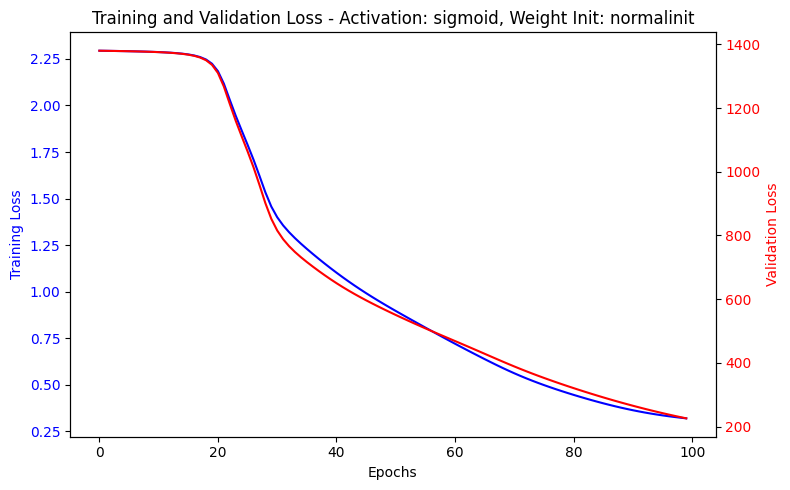

Model with Activation: sigmoid, Weight Init: normalinit - Validation Accuracy: 90.28%, Test Accuracy: 89.73%
Epoch 0 : Train Loss = 2.2967 , Validation Loss = 1380.8047
Epoch 10 : Train Loss = 2.2918 , Validation Loss = 1380.5913
Early Stopping at Epoch 15


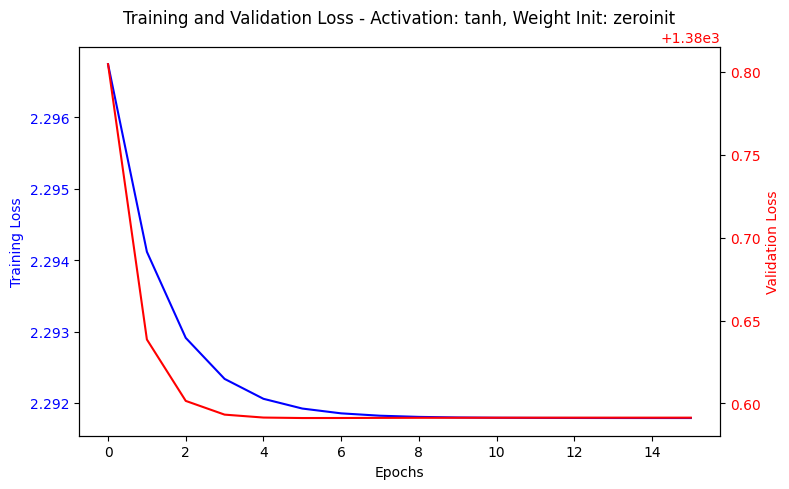

Model with Activation: tanh, Weight Init: zeroinit - Validation Accuracy: 11.37%, Test Accuracy: 10.67%
Epoch 0 : Train Loss = 0.3781 , Validation Loss = 251.4534
Epoch 10 : Train Loss = 0.1037 , Validation Loss = 91.2956
Epoch 20 : Train Loss = 0.0664 , Validation Loss = 66.7662
Epoch 30 : Train Loss = 0.0391 , Validation Loss = 56.6090
Epoch 40 : Train Loss = 0.0242 , Validation Loss = 51.3918
Epoch 50 : Train Loss = 0.0168 , Validation Loss = 48.9311
Epoch 60 : Train Loss = 0.0118 , Validation Loss = 48.0127
Epoch 70 : Train Loss = 0.0085 , Validation Loss = 47.7282
Epoch 80 : Train Loss = 0.0064 , Validation Loss = 47.7825
Early Stopping at Epoch 83


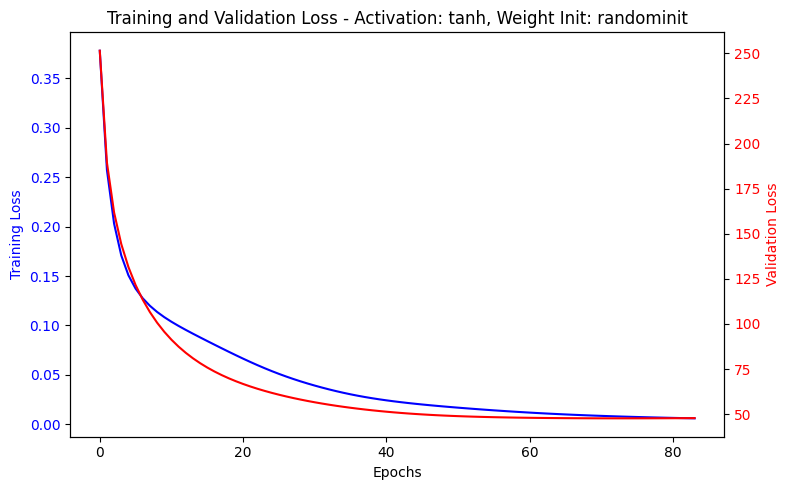

Model with Activation: tanh, Weight Init: randominit - Validation Accuracy: 97.82%, Test Accuracy: 97.53%
Epoch 0 : Train Loss = 0.4427 , Validation Loss = 294.0254
Epoch 10 : Train Loss = 0.1390 , Validation Loss = 101.8472
Epoch 20 : Train Loss = 0.0962 , Validation Loss = 72.0313
Epoch 30 : Train Loss = 0.0668 , Validation Loss = 59.2428
Epoch 40 : Train Loss = 0.0436 , Validation Loss = 52.1710
Epoch 50 : Train Loss = 0.0290 , Validation Loss = 48.3912
Epoch 60 : Train Loss = 0.0197 , Validation Loss = 46.6034
Epoch 70 : Train Loss = 0.0138 , Validation Loss = 45.7069
Epoch 80 : Train Loss = 0.0101 , Validation Loss = 45.3274
Epoch 90 : Train Loss = 0.0076 , Validation Loss = 45.2085


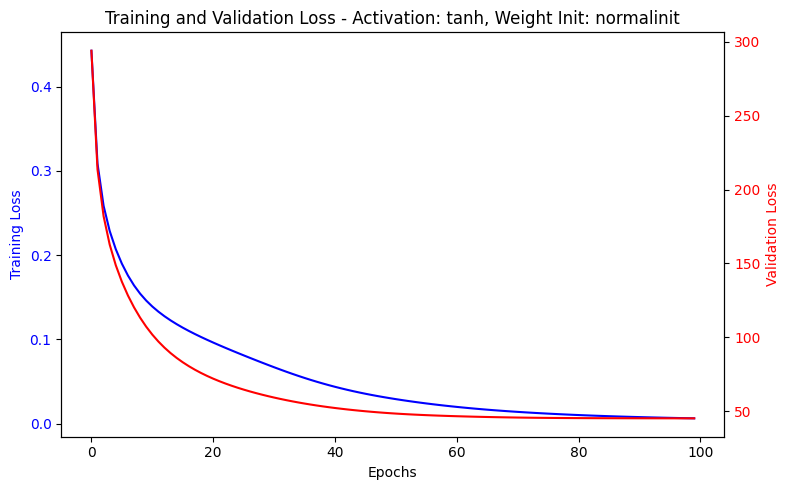

Model with Activation: tanh, Weight Init: normalinit - Validation Accuracy: 97.98%, Test Accuracy: 97.50%
Epoch 0 : Train Loss = 2.2967 , Validation Loss = 1380.8047
Epoch 10 : Train Loss = 2.2918 , Validation Loss = 1380.5913
Early Stopping at Epoch 15


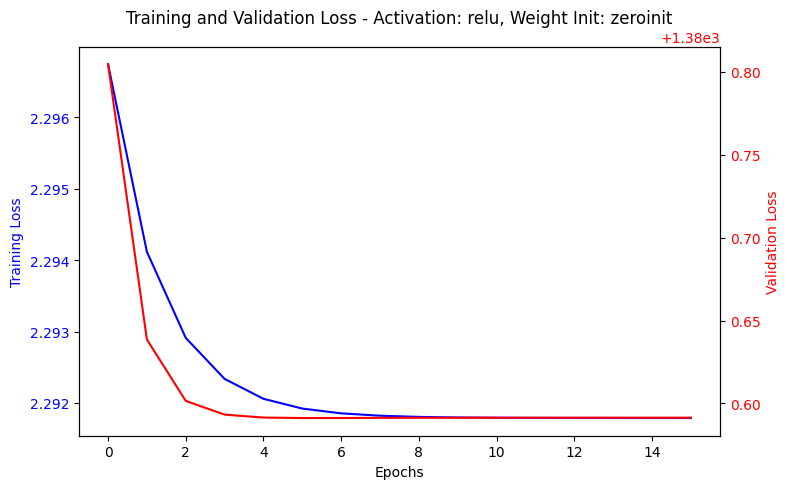

Model with Activation: relu, Weight Init: zeroinit - Validation Accuracy: 11.37%, Test Accuracy: 10.67%
Epoch 0 : Train Loss = 0.3261 , Validation Loss = 223.1471
Epoch 10 : Train Loss = 0.0835 , Validation Loss = 74.3370
Epoch 20 : Train Loss = 0.0316 , Validation Loss = 54.7723
Epoch 30 : Train Loss = 0.0111 , Validation Loss = 49.3456
Epoch 40 : Train Loss = 0.0052 , Validation Loss = 49.0130
Early Stopping at Epoch 46


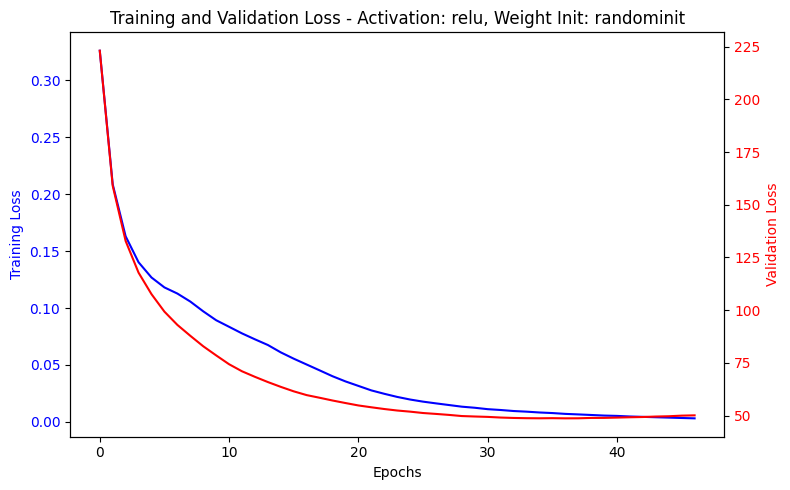

Model with Activation: relu, Weight Init: randominit - Validation Accuracy: 97.63%, Test Accuracy: 97.40%
Epoch 0 : Train Loss = 0.4173 , Validation Loss = 263.1911
Epoch 10 : Train Loss = 0.0978 , Validation Loss = 76.6824
Epoch 20 : Train Loss = 0.0514 , Validation Loss = 55.1455
Epoch 30 : Train Loss = 0.0250 , Validation Loss = 50.5407
Early Stopping at Epoch 39


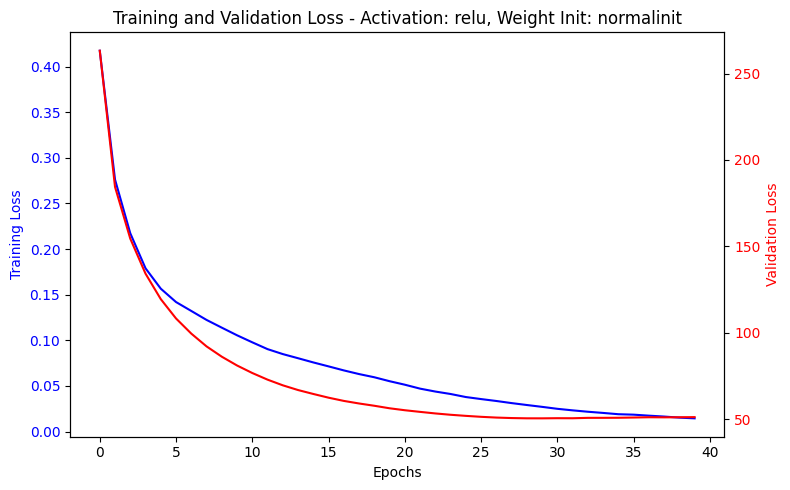

Model with Activation: relu, Weight Init: normalinit - Validation Accuracy: 97.53%, Test Accuracy: 97.12%
Epoch 0 : Train Loss = 2.2967 , Validation Loss = 1380.8047
Epoch 10 : Train Loss = 2.2918 , Validation Loss = 1380.5913
Early Stopping at Epoch 15


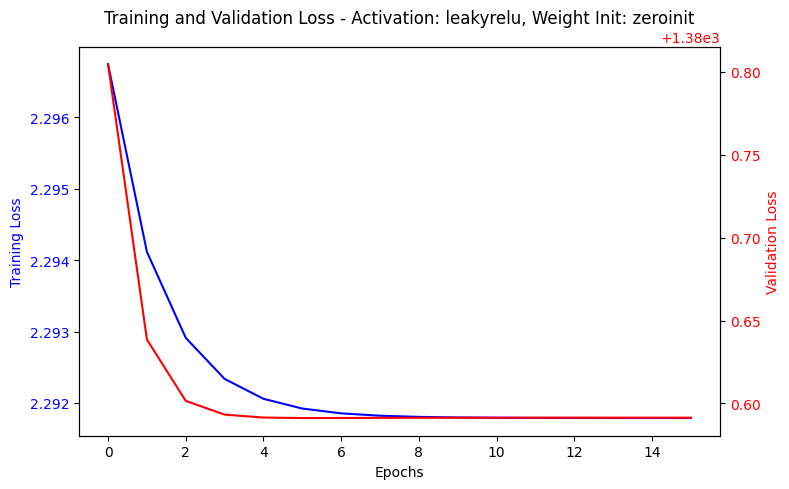

Model with Activation: leakyrelu, Weight Init: zeroinit - Validation Accuracy: 11.37%, Test Accuracy: 10.67%
Epoch 0 : Train Loss = 0.3372 , Validation Loss = 201.9653
Epoch 10 : Train Loss = 0.0751 , Validation Loss = 71.2743
Epoch 20 : Train Loss = 0.0271 , Validation Loss = 58.2081
Epoch 30 : Train Loss = 0.0133 , Validation Loss = 58.4277
Early Stopping at Epoch 35


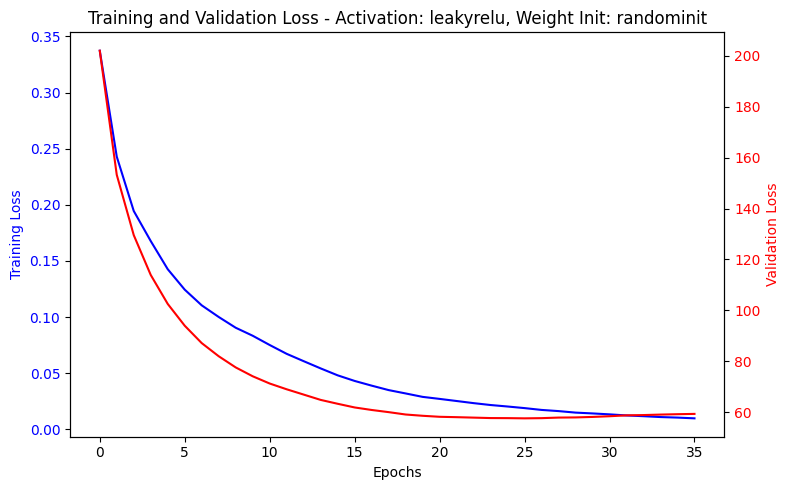

Model with Activation: leakyrelu, Weight Init: randominit - Validation Accuracy: 97.32%, Test Accuracy: 97.08%
Epoch 0 : Train Loss = 0.4687 , Validation Loss = 274.5928
Epoch 10 : Train Loss = 0.1141 , Validation Loss = 72.8042
Epoch 20 : Train Loss = 0.0606 , Validation Loss = 53.6498
Epoch 30 : Train Loss = 0.0282 , Validation Loss = 50.7108
Epoch 40 : Train Loss = 0.0115 , Validation Loss = 51.7272
Early Stopping at Epoch 40


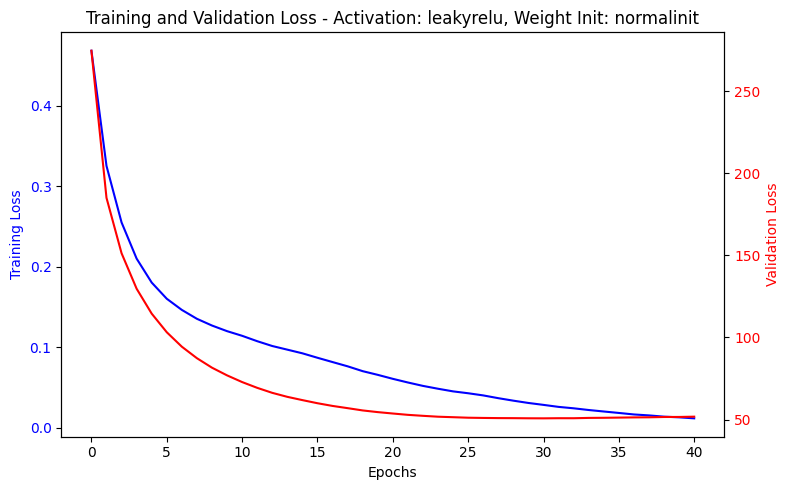

Model with Activation: leakyrelu, Weight Init: normalinit - Validation Accuracy: 97.60%, Test Accuracy: 97.18%


In [ ]:
actFunctions = ['sigmoid' , 'tanh' , 'relu' , 'leakyrelu']
weightsinit = ['zeroinit' , 'randominit' , 'normalinit']
modelsTrained = []
for a in actFunctions:
    for w in weightsinit:
        model = NeuralNetwork(
            hiddenlayers=4 ,
            neuronperlayer=[784 , 256 , 128 , 64 , 32 ,  10] ,
            activationfn=a ,
            weightinit = w ,
            epochs=100,
            batchSize=128,
            lr=2e-2,
            earlystop=True,
            patience=10
        )
        trainLosses , valLosses = model.fit(XTrainSplit , YTrainSplit , XValSplit , YValSplit)
        fig, ax1 = plt.subplots(figsize=(8, 5))
        ax1.plot(trainLosses, color='blue', label='Training Loss')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Training Loss', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')
        ax2 = ax1.twinx()
        ax2.plot(valLosses, color='red', label='Validation Loss')
        ax2.set_ylabel('Validation Loss', color='red')
        ax2.tick_params(axis='y', labelcolor='red')
        plt.title(f'Training and Validation Loss - Activation: {a}, Weight Init: {w}')
        fig.tight_layout()
        plt.show()
        nameFile = f'{a}_{w}.pkl'
        with open(nameFile , 'wb') as f:
            pickle.dump(model , f)
        modelsTrained.append(model)
        valAccuracy = model.score(XValSplit, YValSplit)
        testAccuracy = model.score(XTestSplit, YTestSplit)
        print(f'Model with Activation: {a}, Weight Init: {w} - Validation Accuracy: {valAccuracy*100:.2f}%, Test Accuracy: {testAccuracy*100:.2f}%')
# model = NeuralNetwork(
#     hiddenlayers=4 ,
#     neuronperlayer=[784 , 256 , 128 , 64 , 32 ,  10] ,
#     activationfn='relu' ,
#     weightinit = 'randominit' ,
#     epochs=100,
#     batchSize=128,
#     lr=2e-2
# )
# model.fit(XTrainSplit , YTrainSplit , XValSplit , YValSplit)
# ValAcc = model.score(XValSplit , YValSplit)
# TestAcc = model.score(XTestSplit , YTestSplit)
# print(f'Validation Accuracy : {ValAcc*100:.2f}%')
# print(f'Test Accuracy : {TestAcc*100:.2f}%')

In [76]:
actFunctions = ['sigmoid' , 'tanh' , 'relu' , 'leakyrelu']
weightsinit = ['zeroinit' , 'randominit' , 'normalinit']
testRes = {}
for a in actFunctions:
    for w in weightsinit:
        fileName = f'{a}_{w}.pkl'
        if os.path.exists(fileName):
            with open(fileName , 'rb') as f:
                model = pickle.load(f)
            validationAccuracy = model.score(XValSplit , YValSplit)
            testAccuracy = model.score(XTestSplit , YTestSplit)
            testRes[f'{a}_{w}'] = testAccuracy
            print(f'Model with Activation: {a}, Weight Init: {w} -Validation Accuracy:{validationAccuracy*100:.2f}%, Test Accuracy: {testAccuracy*100:.2f}%')

Model with Activation: sigmoid, Weight Init: zeroinit -Validation Accuracy:11.37%, Test Accuracy: 10.67%
Model with Activation: sigmoid, Weight Init: randominit -Validation Accuracy:92.53%, Test Accuracy: 92.10%
Model with Activation: sigmoid, Weight Init: normalinit -Validation Accuracy:90.28%, Test Accuracy: 89.73%
Model with Activation: tanh, Weight Init: zeroinit -Validation Accuracy:11.37%, Test Accuracy: 10.67%
Model with Activation: tanh, Weight Init: randominit -Validation Accuracy:97.82%, Test Accuracy: 97.53%
Model with Activation: tanh, Weight Init: normalinit -Validation Accuracy:97.98%, Test Accuracy: 97.50%
Model with Activation: relu, Weight Init: zeroinit -Validation Accuracy:11.37%, Test Accuracy: 10.67%
Model with Activation: relu, Weight Init: randominit -Validation Accuracy:97.63%, Test Accuracy: 97.40%
Model with Activation: relu, Weight Init: normalinit -Validation Accuracy:97.53%, Test Accuracy: 97.12%
Model with Activation: leakyrelu, Weight Init: zeroinit -Vali